# Figures of results

Data from: https://open-traffic.epfl.ch

In [1]:
import itertools
import json
import logging
import os
import warnings
from math import exp

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from numpy import arange, array, loadtxt, unique, where
from numpy.polynomial import Polynomial
from scipy.optimize import minimize
from scipy.stats import linregress

In [2]:
from pNeuma_simulator import params
from pNeuma_simulator.results import confidence_interval, normalized

In [3]:
warnings.filterwarnings("ignore")
rcParams["animation.embed_limit"] = 2**128
rcParams.update(
    {
        "pdf.fonttype": 42,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica"],
        "mathtext.fontset": "stix",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
    }
)
# LaTeX packages
plt.rc("text", usetex=False)
plt.rc(
    "text.latex",
    preamble=r"\usepackage{amsmath}",
)
plt.rc("text.latex", preamble=r"\usepackage{gensymb}")
logging.getLogger("matplotlib.font_manager").disabled = True
dark_blue = "#1964B0"
dark_teal = "#008A69"
vermilion = "#DB5829"
orange = "#F4A637"
maroon = "#894B45"
dark_purple = "#882D71"
light_purple = "#D2BBD7"
grey = "#DEDEDE"
yellow = "#E9DC6D"

## Data imports

In [4]:
path = "./output/"
os.makedirs(path, exist_ok=True)
with open(f"{path}results_r.json") as openfile:
    results = json.load(openfile)

In [5]:
in_path = "./input/"
os.makedirs(in_path, exist_ok=True)
with open(f"{in_path}validation.txt") as openfile:
    l_density, l_flow = loadtxt("./input/validation.txt")
mask = array(l_flow) > 400
a_density = array(l_density)[mask]
a_flow = array(l_flow)[mask]

# Results

In [6]:
# consider only this last fraction of the simulated data
keep = 1 / 3
# Pseudorandom number generator
seed = 1024
rng = np.random.default_rng(seed)

In [7]:
# Combinatorial configurations
n_veh = 8
scale = 2
l_cars = scale * arange(1, n_veh, 1)
l_moto = scale * arange(0, n_veh - 1, 1)
permutations = list(itertools.product(l_cars, l_moto))
len(permutations)

49

In [8]:
l_flow_cars = []
l_flow_moto = []
l_speed_cars = []
l_speed_moto = []
l_sem_cars = []
l_sem_moto = []
l_error = []
for permutation in permutations:
    flow_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / (2e-6 * keep * params.T * params.L / params.factor)
    speed_cars = np.nanmean(results[str(permutation)]["VKT_cars"]) / np.nanmean(results[str(permutation)]["VHT_cars"])
    sem_cars = confidence_interval(results[str(permutation)]["VKT_cars"], rng) / np.nanmean(
        results[str(permutation)]["VHT_cars"]
    )
    if permutation[1] > 0:
        flow_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / (
            2e-6 * keep * params.T * params.L / params.factor
        )
        speed_moto = np.nanmean(results[str(permutation)]["VKT_moto"]) / np.nanmean(
            results[str(permutation)]["VHT_moto"]
        )
        sem_moto = confidence_interval(results[str(permutation)]["VKT_moto"], rng) / np.nanmean(
            results[str(permutation)]["VHT_moto"]
        )
    else:
        speed_moto = np.nan
        sem_moto = np.nan
        flow_moto = np.nan
    error = results[str(permutation)]["error"]
    l_flow_cars.append(flow_cars)
    l_flow_moto.append(flow_moto)
    l_speed_cars.append(speed_cars)
    l_speed_moto.append(speed_moto)
    l_sem_cars.append(sem_cars)
    l_sem_moto.append(sem_moto)
    l_error.append(error)

In [9]:
moto_matrix, car_matrix = np.meshgrid(arange(n_veh - 1), arange(n_veh - 1))
car_matrix += 1
car_matrix *= 2
moto_matrix *= 2
car_density = 1e3 * car_matrix / params.L
moto_density = 1e3 * moto_matrix / (2 * params.L)
flow_matrix_cars = array(l_flow_cars).reshape((n_veh - 1, n_veh - 1))
flow_matrix_moto = array(l_flow_moto).reshape((n_veh - 1, n_veh - 1))
speed_matrix_cars = array(l_speed_cars).reshape((n_veh - 1, n_veh - 1))
speed_matrix_moto = array(l_speed_moto).reshape((n_veh - 1, n_veh - 1))
sem_matrix_cars = array(l_sem_cars).reshape((n_veh - 1, n_veh - 1))
sem_matrix_moto = array(l_sem_moto).reshape((n_veh - 1, n_veh - 1))
error_matrix = array(l_error).reshape((n_veh - 1, n_veh - 1))
percent_matrix = moto_matrix / (2 * car_matrix + moto_matrix)

## Rejection rate

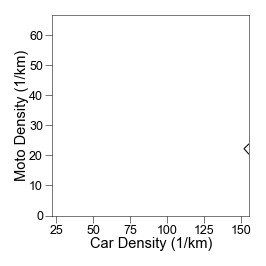

In [10]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    error_matrix,
    levels=arange(0.1, 1, 0.1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
ax.clabel(surface, surface.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

In [11]:
# _ = plt.imshow(error_matrix.T, origin="lower")

## Effect of traffic composition on the capacity

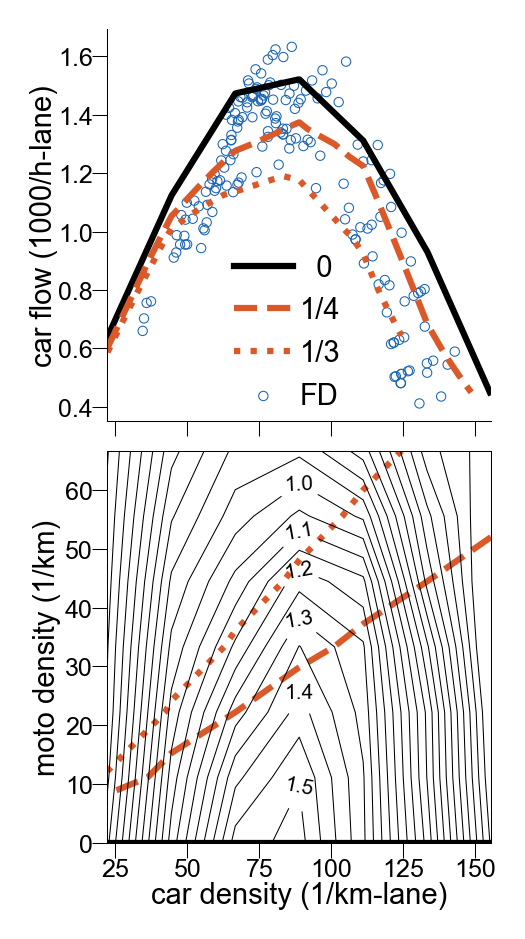

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(4 * params.cm, 7.5 * params.cm), dpi=300, sharex=True)
section = axs[1].contour(
    car_density,
    moto_density,
    percent_matrix,
    levels=[0, 0.25, 0.35],
    colors=[
        "k",
        vermilion,
        vermilion,
    ],
    linestyles=[
        "-",
        "--",
        ":",
    ],
    lw=1.5,
)
major = axs[1].contour(
    car_density,
    moto_density,
    flow_matrix_cars / 1000,
    levels=arange(0.45, 1.6, 0.05),
    colors="k",
    frameon=True,
    linewidths=0.25,
)
axs[1].clabel(major, major.levels[3::2][4:], inline=True, fontsize=5)
minor = axs[1].contour(
    car_density,
    moto_density,
    flow_matrix_cars,
    levels=arange(450, 1600, 1),
    colors="none",
    frameon=True,
)
l_points, l_response = normalized(minor, section)
axs[1].set_xticks(arange(25, 175, 25))
axs[1].set_ylabel("moto density (1/km)", labelpad=1)
axs[1].set_xlabel("car density (1/km-lane)", labelpad=0.1)
axs[1].tick_params(axis="x", pad=0)
axs[1].tick_params(axis="y", pad=0)
linestyles = [
    "-",
    "--",
    ":",
]
labels = ["  0", "1/4", "1/3"]
for n, (points, response) in enumerate(zip(l_points, l_response)):
    variable = []
    for point in l_points[n]:
        variable.append(point[0])
    l_variable = array(variable)
    order = np.argsort(variable)
    variable = np.sort(variable)
    response = array(l_response[n])[order]
    _ = axs[0].plot(
        variable,
        response / 1000,
        c=[
            "k",
            vermilion,
            vermilion,
        ][n],
        ls=linestyles[n],
        label=labels[n],
        lw=1.5,
    )
axs[0].scatter(
    a_density,
    a_flow / 1000,
    ec=dark_blue,
    fc="none",
    s=5,
    lw=0.25,
    zorder=-1,
    label="FD",
)
axs[0].legend(
    loc=(0.3, 0.0),
    frameon=False,
    handletextpad=0.25,
    handlelength=2,
    fontsize=7,
)
axs[0].set_yticks([0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
axs[0].spines[["right", "top"]].set_visible(False)
axs[0].set_ylabel("car flow (1000/h-lane)", labelpad=0)
axs[0].tick_params(axis="y", pad=0)
fig.tight_layout(pad=0.1)
plt.subplots_adjust(hspace=0.075)
# plt.savefig(f"/Users/georg/Documents/Figures/flow_validation.pdf", format="pdf", transparent=True)

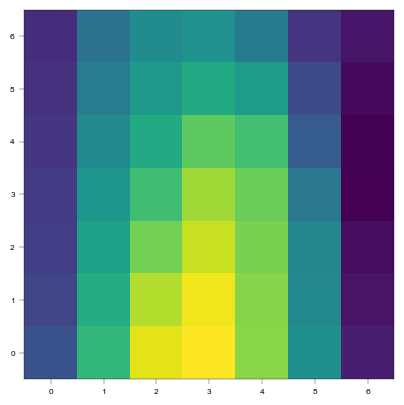

In [13]:
_ = plt.imshow(flow_matrix_cars.T, origin="lower")

In [14]:
flow_matrix_cars[3][0]

1520.65782304834

In [15]:
# TODO: check nonlinearity quantitatively

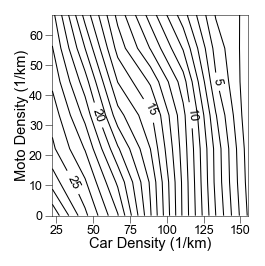

In [16]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    speed_matrix_cars,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.clabel(surface, surface.levels[::5], inline=True, fontsize=6)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"speed_cars.pdf", format="pdf", transparent=True)

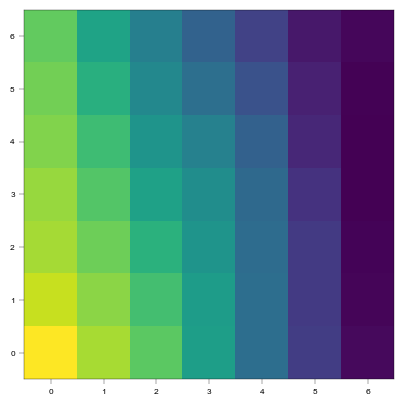

In [17]:
_ = plt.imshow(speed_matrix_cars.T, origin="lower")

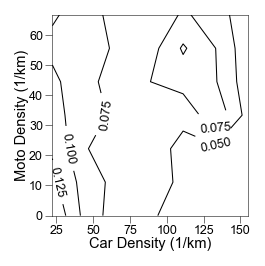

In [18]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    sem_matrix_cars,
    levels=arange(0, 1, 0.025),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.clabel(surface, surface.levels, inline=True, fontsize=6)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)

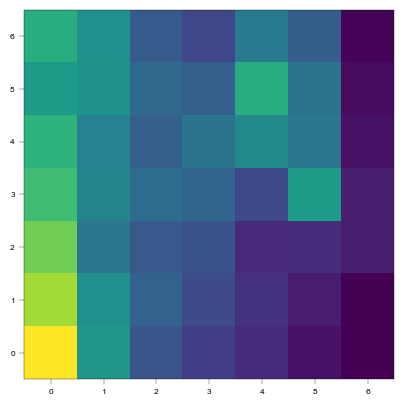

In [19]:
_ = plt.imshow(sem_matrix_cars.T, origin="lower")

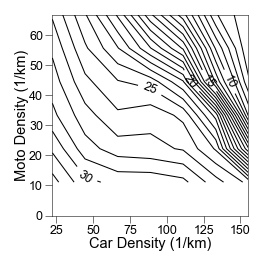

In [20]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    speed_matrix_moto,
    levels=arange(0, 40, 1),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.clabel(surface, surface.levels[::5], inline=True, fontsize=6)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"speed_moto.pdf", format="pdf", transparent=True)

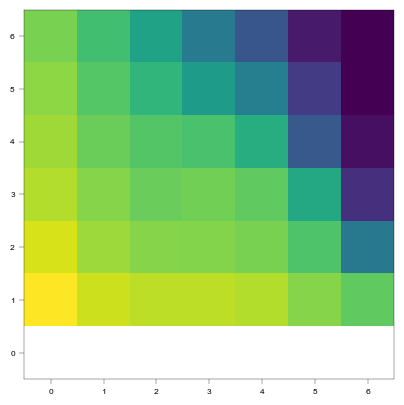

In [21]:
_ = plt.imshow(speed_matrix_moto.T, origin="lower")

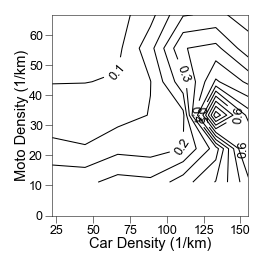

In [22]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density,
    moto_density,
    sem_matrix_moto,
    levels=arange(0, 2, 0.05),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(25, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
ax.clabel(surface, surface.levels[::2], inline=True, fontsize=6)
fig.tight_layout(pad=0)

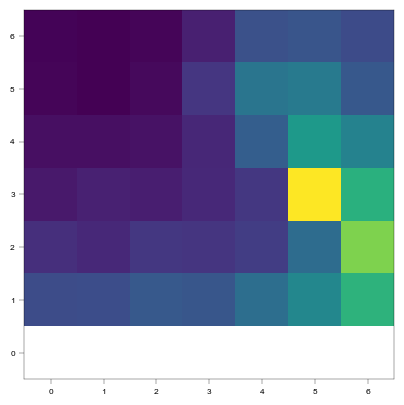

In [23]:
_ = plt.imshow(
    sem_matrix_moto.T,
    origin="lower",
)

## Phase transitions

In [23]:
T_max = round(exp(params.CM))
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [24]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [25]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(np.diff(np.sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [26]:
l_T_c = []
l_p_c = []
l_slope = []
r_values = []
p_values = []
for permutation in permutations:
    if permutation[0] > 2 and permutation[1] > 4:
        try:
            (
                x,
                y,
                _,
                _,
            ) = results[
                str(permutation)
            ]["percolation"]
        except:
            (
                x,
                y,
                _,
                _,
                _,
            ) = results[
                str(permutation)
            ]["percolation"]
        x, y = array(x), array(y)
        try:
            T_c = fit(x, y)
            renorm = np.abs(T_c - x)
            slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
            r_values.append(r_value)
            p_values.append(p_value)
            p_c = 1 - T_c / T_max
            if r_value < 0.95:
                print(permutation, r_value)
                T_c = np.nan
                p_c = np.nan
            else:
                l_slope.append(slope)
        except:
            print(f"problem{permutation}")
            break
    else:
        T_c = np.nan
        p_c = np.nan
    l_T_c.append(T_c)
    l_p_c.append(p_c)
moto_matrix, car_matrix = np.meshgrid(arange(n_veh - 1), arange(n_veh - 1))
car_matrix += 1
car_matrix *= 2
moto_matrix *= 2
percolation_matrix = array(l_p_c).reshape((n_veh - 1, n_veh - 1))
temperature_matrix = array(l_T_c).reshape((n_veh - 1, n_veh - 1))

In [27]:
round(np.mean(r_values), 4), round(np.mean(p_values), 15), round(np.std(l_slope), 6)

(0.9966, 5e-15, 1.3e-05)

In [28]:
# _ = plt.imshow(
#    percolation_matrix.T,
#    origin="lower",
# )

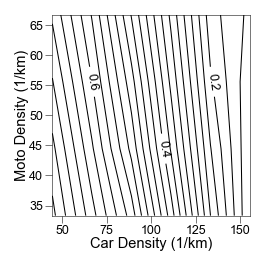

In [29]:
fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
surface = ax.contour(
    car_density[1:, 3:],
    moto_density[1:, 3:],
    percolation_matrix[1:, 3:],
    levels=arange(0, 1, 0.025),
    colors="k",
    linewidths=0.5,
)
ax.set_xticks(arange(50, 175, 25))
ax.set_ylabel("Moto Density (1/km)", labelpad=0)
ax.set_xlabel("Car Density (1/km)", labelpad=0)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
ax.clabel(surface, surface.levels[::8], inline=True, fontsize=6)
fig.tight_layout(pad=0)

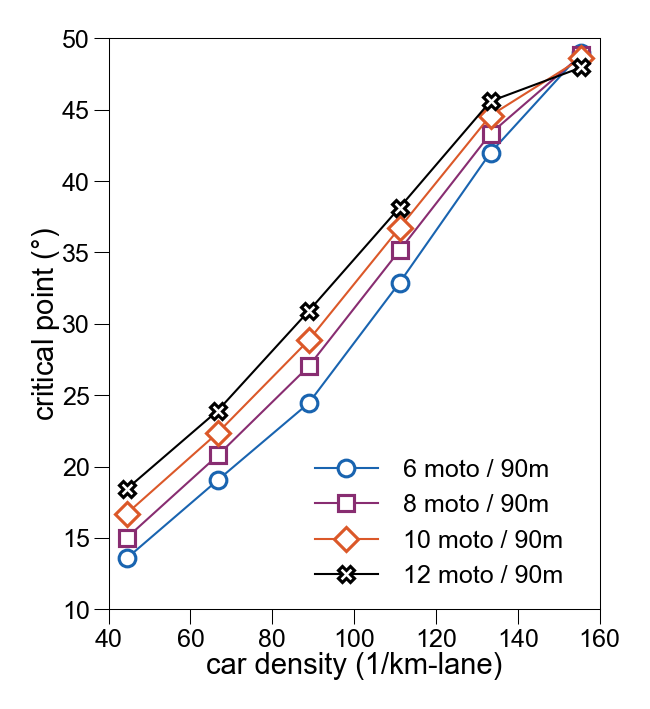

In [55]:
fig, ax = plt.subplots(figsize=(5 * params.cm, 5.5 * params.cm), dpi=300)
markers = ["o-", "s-", "D-", "X-"]
colors = [dark_blue, dark_purple, vermilion, "k"]
for i in range(4):
    ax.plot(
        car_density[1:, i + 3],
        temperature_matrix[1:, i + 3],
        markers[i],
        c=colors[i],
        lw=0.5,
        ms=4,
        mfc="w",
        mew=".75",
        label=f"{2*(i+3)} moto / 90m",
    )
ax.set_ylabel("critical point ($\\degree$)", labelpad=0)
ax.set_xlabel("car density (1/km-lane)", labelpad=0)
ax.legend(
    loc=[0.4, 0.02],
    frameon=False,
    handletextpad=1,
    labelspacing=0.5,
    handlelength=2.5,
    fontsize=6,
)
ax.set_ylim(10, 50)
ax.set_xlim(40, 160)
ax.set_xticks(arange(40, 180, 20))
ax.set_yticks(arange(10, 55, 5))
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig("/Users/georg/Documents/Figures/criticality.pdf", format="pdf", transparent=True)
plt.savefig("./output/figures/criticality.pdf", format="pdf", transparent=True)

In [31]:
def draw_law(x, y, r_value, save=False):
    fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
    ax.set_aspect("equal")
    _ = plt.loglog(
        x[y > 0],
        y[y > 0],
        ".",
        mec="k",
        mfc="none",
        ms=5,
        mew=0.25,
    )
    p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
    plt.plot(
        np.exp(unique(np.log(x)[y > 0])),
        np.exp(p_fitted(unique(np.log(x)[y > 0]))),
        c="k",
        ls="-",
        lw=0.5,
    )
    ax.text(
        0.05,
        0.95,
        f"$R^2$= {r_value:.3f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.07,
        0.8,
        f"$\\nu$= {slope:.4f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.2,
        f"$T_c$= {T_c:.2f}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.05,
        f"permutation {permutation}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.set_ylabel("$\\langle \\Delta \\Phi \\rangle^+$", usetex=True, labelpad=0)
    ax.set_xlabel("$|T-T_c|$", usetex=True, labelpad=0)
    ax.tick_params(axis="x", pad=0)
    ax.tick_params(axis="y", pad=0)
    fig.tight_layout(pad=0)
    if save:
        plt.savefig(
            # f"./power-laws/power-law{permutation}.pdf", format="pdf", transparent=True
            f"./power-law{permutation}.pdf",
            format="pdf",
            transparent=True,
        )

In [32]:
# for permutation in permutations:
#    if permutation[0] > 2 and permutation[1] > 4:
#        x, y, low, high = results[str(permutation)]["percolation"]
#        x, y, low, high = array(x), array(y), array(low), array(high)
#        T_c = fit(array(x), y)
#        renorm = np.abs(T_c - x)
#        slope, intercept, r_value, p_value, std_err = linregress(
#            np.log(renorm)[y > 0], np.log(y[y > 0])
#        )
#        p_c = 1 - T_c / T_max
#        draw_law(renorm, y, save=True)

In [33]:
def statistics(results, permutation, temperature_matrix):
    i = permutation[1] / 2 - 3
    j = permutation[0] / 2 - 1
    T_c = temperature_matrix[int(j), int(i) + 3]
    if permutation[0] == 10:
        marker = "-o"
    elif permutation[0] == 12:
        marker = "-s"
    else:
        marker = "-D"
    if permutation[1] == 6:
        c = dark_blue
        zorder = 10
    elif permutation[1] == 8:
        c = dark_purple
        zorder = 20
    elif permutation[1] == 10:
        c = vermilion
        zorder = 50
    else:
        c = "k"
        zorder = 100
    try:
        x, y, low, high = results[str(permutation)]["percolation"]
        x, y, low, high = array(x), array(y), array(low), array(high)
    except:
        x, y, low, high, cumulant = results[str(permutation)]["percolation"]
        x, y, low, high, cumulant = array(x), array(y), array(low), array(high), array(cumulant)
    # https://stackoverflow.com/questions/62525535/
    yerr = np.array(list(zip(y - low, high - y))).T
    x -= T_c
    try:
        return x, y, yerr, cumulant, c, zorder, marker
    except:
        return (x, y, yerr, c, zorder, marker)

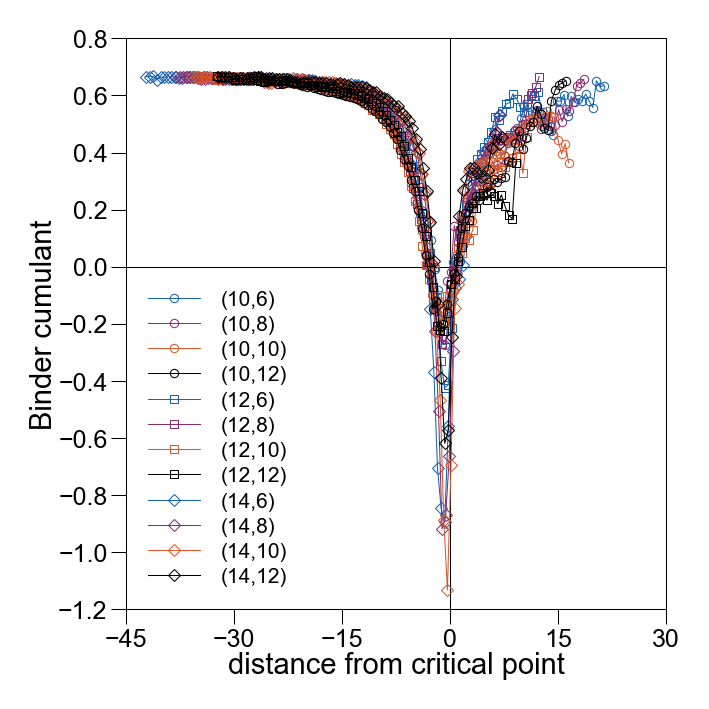

In [54]:
fig, ax = plt.subplots(figsize=(5.5 * params.cm, 5.5 * params.cm), dpi=300)
ms = 4
lw = 0.25
for permutation in permutations:
    n_cars, n_moto = permutation
    if n_cars > 8 and n_moto > 4:
        try:
            x, y, yerr, cumulant, c, zorder, marker = statistics(results, permutation, temperature_matrix)
            ax.plot(
                x,
                cumulant,
                marker,
                lw=0.25,
                ms=2,
                mfc="None",
                mew=".25",
                c=c,
                zorder=zorder,
                label=f"({n_cars},{n_moto})",
            )
        except:
            x, y, yerr, c, zorder, marker = statistics(results, permutation, temperature_matrix)
ax.axvline(0, c="k", lw=lw, zorder=1)
ax.axhline(0, c="k", lw=lw, zorder=1)
legend = ax.legend(
    loc=[0.025, 0.025],
    frameon=True,
    handletextpad=1,
    labelspacing=0.3,
    handlelength=2.5,
    fontsize=5,
)
frame = legend.get_frame()
frame.set_color("None")
frame.set_fc("white")
frame.set_alpha(1)
ax.set_xlabel("distance from critical point", labelpad=0)
ax.set_ylabel("Binder cumulant", labelpad=0)
ax.set_xlim(-45, 25)
ax.set_xticks(arange(-45, 45, 15))
ax.set_ylim(-0.5, 0.8)
ax.set_yticks(arange(-1.2, 0.9, 0.2))
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"/Users/georg/Documents/Figures/phase-transition.pdf", format="pdf", transparent=False)
plt.savefig(f"./output/figures/phase-transition.pdf", format="pdf", transparent=True)

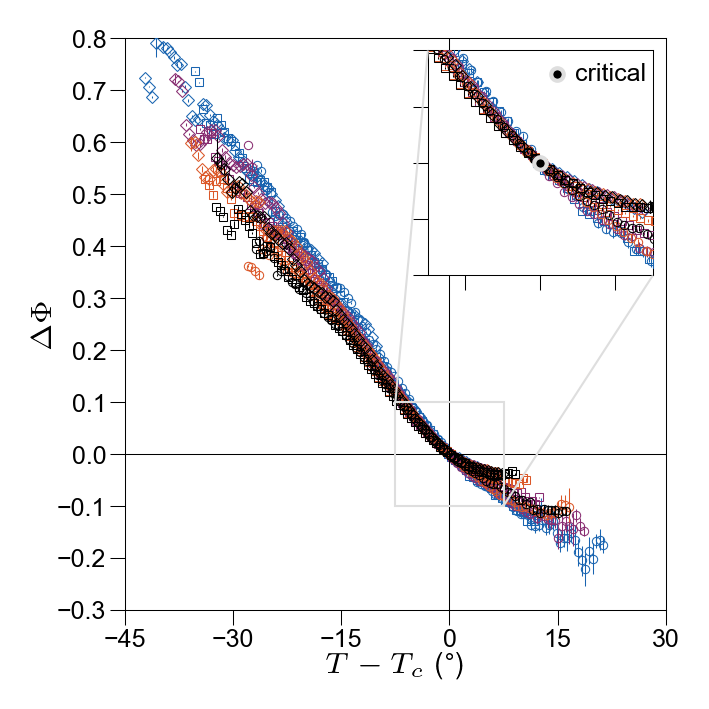

In [41]:
fig, ax = plt.subplots(figsize=(5.5 * params.cm, 5.5 * params.cm), dpi=300)
ms = 2
lw = 0.25
for permutation in permutations:
    n_cars, n_moto = permutation
    if n_cars > 8 and n_moto > 4:
        try:
            x, y, yerr, cumulant, c, zorder, marker = statistics(results, permutation, temperature_matrix)
        except:
            x, y, yerr, c, zorder, marker = statistics(results, permutation, temperature_matrix)
        ax.errorbar(
            x,
            y,
            yerr=yerr,
            ms=ms,
            fmt=marker[-1],
            mec=c,
            mfc="none",
            mew=lw,
            ecolor=c,
            elinewidth=lw,
            zorder=zorder,
        )
ax.axvline(0, c="k", lw=lw, zorder=100)
ax.axhline(0, c="k", lw=lw, zorder=100)
ax.set_xlabel("$T-T_c$  ($\\degree$)", usetex=True, labelpad=0)
ax.set_ylabel("$\\Delta\\Phi$", usetex=True, labelpad=0)
# inset Axes....
axins = inset_axes(ax, 0.75, 0.75, loc=2, bbox_to_anchor=(0.59, 0.99), bbox_transform=ax.figure.transFigure)
x1, x2, y1, y2 = -7.5, 7.5, -0.1, 0.1  # specify the limits
axins.set_xlim(x1, x2)  # apply the x-limits
axins.set_ylim(y1, y2)  # apply the y-limits
for permutation in permutations:
    n_cars, n_moto = permutation
    if n_cars > 8 and n_moto > 4:
        try:
            x, y, yerr, cumulant, c, zorder, marker = statistics(results, permutation, temperature_matrix)
        except:
            x, y, yerr, c, zorder, marker = statistics(results, permutation, temperature_matrix)
        axins.errorbar(
            x,
            y,
            yerr=yerr,
            ms=ms,
            fmt=marker[-1],
            mec=c,
            mfc="none",
            mew=0.25,
            ecolor=c,
            elinewidth=0.25,
            zorder=zorder,
        )
axins.scatter(0, 0, marker=".", zorder=200, ec=grey, fc="k", label="critical")
plt.xticks(visible=False)
plt.yticks(visible=False)
axins.legend(
    loc=[0.5, 0.8],
    frameon=False,
    handletextpad=0.5,
    handlelength=0.5,
    fontsize=6,
)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", lw=0.5, zorder=200, ec=grey)
ax.set_xlim(-45, 25)
ax.set_xticks(arange(-45, 45, 15))
ax.set_ylim(-0.3, 0.8)
ax.set_yticks(arange(-0.3, 0.9, 0.1))
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)

1.099746580427555 0.9898973521682779


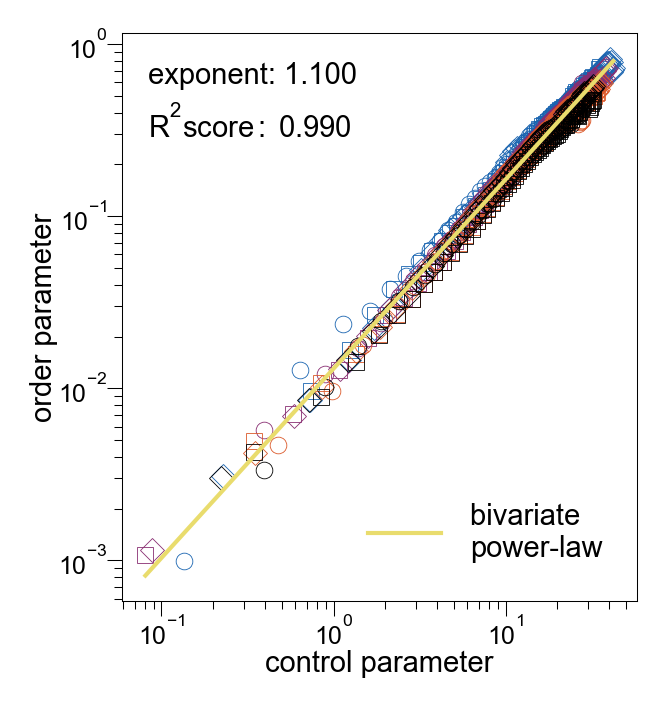

In [53]:
fig, ax = plt.subplots(figsize=(5.5 * params.cm, 5.5 * params.cm), dpi=300)
x_data = []
y_data = []
for permutation in permutations:
    n_cars, n_moto = permutation
    if n_cars > 8 and n_moto > 4:
        try:
            x, y, yerr, cumulant, c, zorder, marker = statistics(results, permutation, temperature_matrix)
        except:
            x, y, yerr, c, zorder, marker = statistics(results, permutation, temperature_matrix)
        renorm = abs(x)
        x_data.extend(renorm)
        y_data.extend(y)
        ax.set_aspect("equal")
        _ = plt.loglog(
            renorm[y > 0],
            y[y > 0],
            marker[-1],
            mec=c,
            mfc="none",
            ms=ms,
            mew=0.2,
            zorder=zorder,
        )
x = array(x_data)
y = array(y_data)
p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
slope, intercept, r_value, p_value, std_err = linregress(np.log(x[y > 0]), np.log(y[y > 0]))
print(slope, r_value**2)
plt.plot(
    np.exp(unique(np.log(x)[y > 0])),
    np.exp(p_fitted(unique(np.log(x)[y > 0]))),
    c=yellow,
    ls="-",
    lw=1,
    zorder=1000,
    label="bivariate \npower-law",
)
ax.text(
    0.05,
    0.875,
    f"$R^2 score:$ {r_value**2:.3f}",
    ha="left",
    va="top",
    fontsize=7,
    transform=ax.transAxes,
)
ax.text(
    0.05,
    0.95,
    f"exponent: {slope:.3f}",
    ha="left",
    va="top",
    fontsize=7,
    transform=ax.transAxes,
)

ax.legend(
    frameon=False,
    borderpad=0,
    handletextpad=1,
    handlelength=2.5,
    fontsize=7,
    loc=2,
    bbox_to_anchor=(0.45, 0.2),
)
ax.set_ylabel("order parameter", labelpad=0)
ax.set_xlabel("control parameter", labelpad=0)
ax.tick_params(axis="x", pad=0)
ax.tick_params(axis="y", pad=0)
fig.tight_layout(pad=0)
# plt.savefig("/Users/georg/Documents/Figures/power-law.pdf", format="pdf", transparent=True)
plt.savefig("./output/figures/power-law.pdf", format="pdf", transparent=True)

In [46]:
permutation = (12, 6)
x, y, low, high, _ = results[str(permutation)]["percolation"]
x, y, low, high = array(x), array(y), array(low), array(high)
T_c = fit(array(x), y)
renorm = abs(T_c - x)
slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
p_c = 1 - T_c / T_max
print(abs(NU - slope), T_c)

3.2566482881524195e-06 41.99454689025879


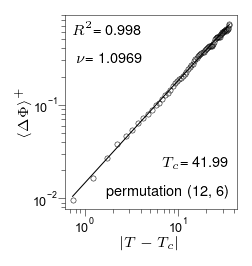

In [48]:
draw_law(renorm, y, r_value**2, save=False)